## Objective

Does RFs give me 0.5-0.6-ish R2 performance, now that I've removed outliers? If so, check for multicolinearity and interpret Variable Importance Plot.

In [1]:
import os, sys
sys.path.append(os.path.join(os.path.dirname('.'), "../preprocessing"))

In [2]:
from transform_for_num_issues_pred import main as transform_dataset

In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set_style("whitegrid")
sns.set_context("poster")
rcParams['figure.figsize'] = 20, 5

from helper_functions import dummify_cols_and_baselines, make_alphas, adjusted_r2

In [4]:
df_orig = pd.read_pickle('../data/data_from_remove_from_dataset.pkl')
df_orig.shape

(516406, 40)

In [5]:
df_transformed = transform_dataset(df_orig)
df_transformed.shape

../preprocessing/transform_for_num_issues_pred.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_subset['NUM_ISSUES'] = 1


(534, 28)

## Choosing columns

In [8]:
cols_orig_dataset = ['NUM_ISSUES_PER_1000_POP']
cols_census = ['race_white',
     'race_black',
     'race_asian',
     'race_hispanic',
     'race_other',
     'poverty_pop_below_poverty_level',
     'earned_income_per_capita',
     'poverty_pop_w_public_assistance',
     'poverty_pop_w_food_stamps',
     'poverty_pop_w_ssi',
     'school',
     'school_std_dev',
     'housing',
     'housing_std_dev',
     'bedroom',
     'bedroom_std_dev',
     'value',
     'value_std_dev',
     'rent',
     'rent_std_dev',
     'income',
     'income_std_dev']

In [9]:
df_col_subset = df_transformed[cols_orig_dataset + cols_census]
df_col_subset.shape

(534, 23)

## Dummify

In [11]:
cols_to_dummify = df_col_subset.dtypes[df_col_subset.dtypes == object].index
cols_to_dummify

Index([u'school', u'housing'], dtype='object')

In [12]:
df_dummified, baseline_cols = dummify_cols_and_baselines(df_col_subset, cols_to_dummify)

8_6th_grade is baseline 0 2
rent is baseline 1 2


In [13]:
df_dummified.shape

(534, 32)

## Running model

In [14]:
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer


/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    df_dummified.drop('NUM_ISSUES_PER_1000_POP', axis=1), 
    df_dummified.NUM_ISSUES_PER_1000_POP, 
    test_size=0.2,
    random_state=500
)

In [16]:
pipe = make_pipeline(RandomForestRegressor())

In [49]:
mse = make_scorer(mean_squared_error, greater_is_better=False)
adjusted_r2_scorer = make_scorer(adjusted_r2, num_features=X_test.shape[1])

In [50]:
params = {'randomforestregressor__max_depth': [150], 
          'randomforestregressor__n_estimators': [50],
          'randomforestregressor__max_features': [0.3]
         }
model = GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=5, scoring=adjusted_r2_scorer)
model.fit(X_train, y_train)
results = pd.DataFrame(model.cv_results_).T

In [51]:
model.best_score_

-0.09059883283762403

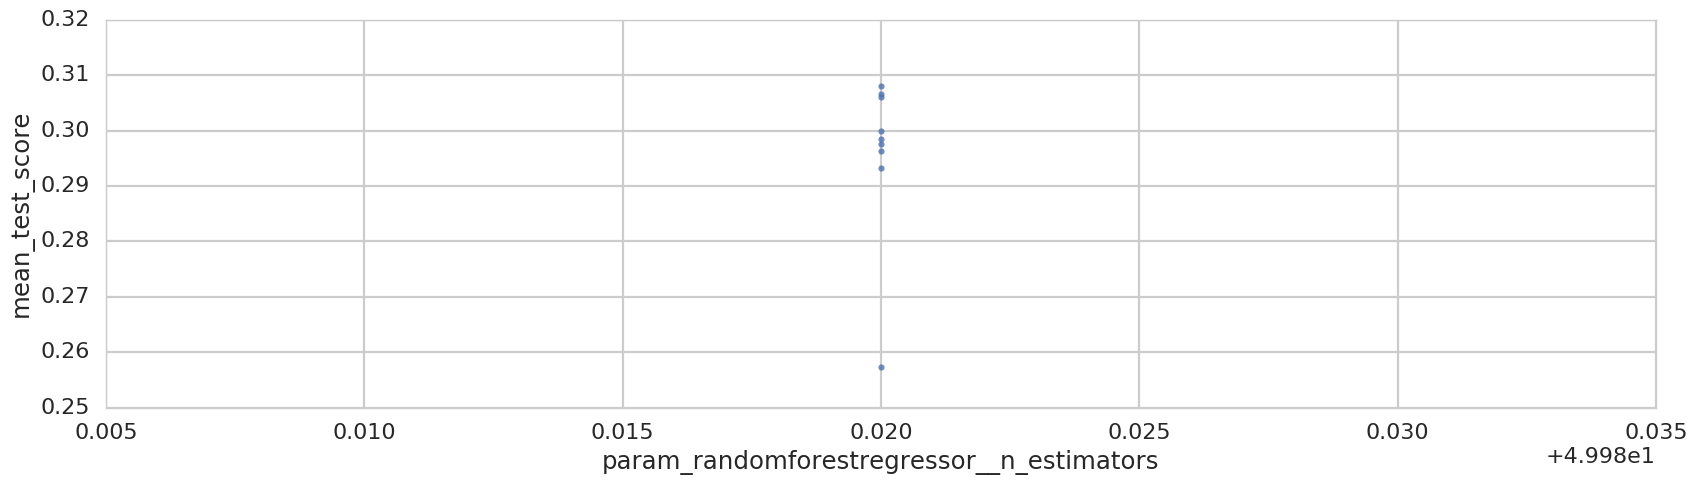

In [38]:
sns.regplot(
    x='param_randomforestregressor__n_estimators',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__n_estimators', 'mean_test_score']], 
    fit_reg=False
);

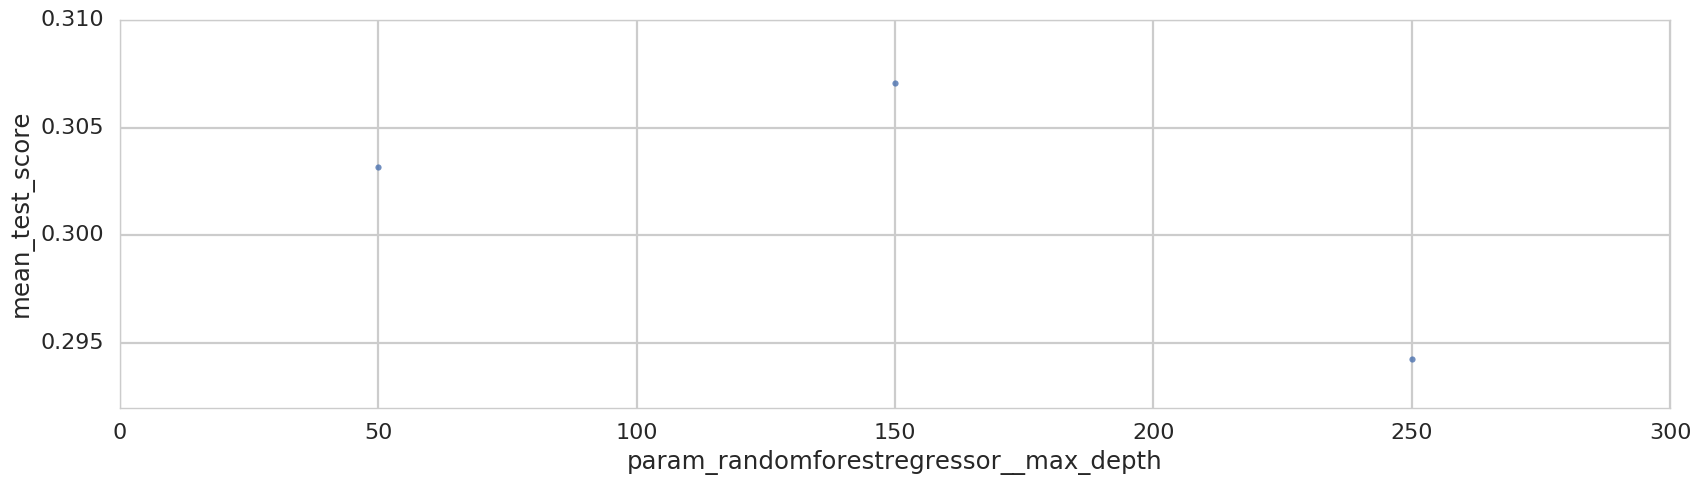

In [43]:
sns.regplot(
    x='param_randomforestregressor__max_depth',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__max_depth', 'mean_test_score']], 
    fit_reg=False
);

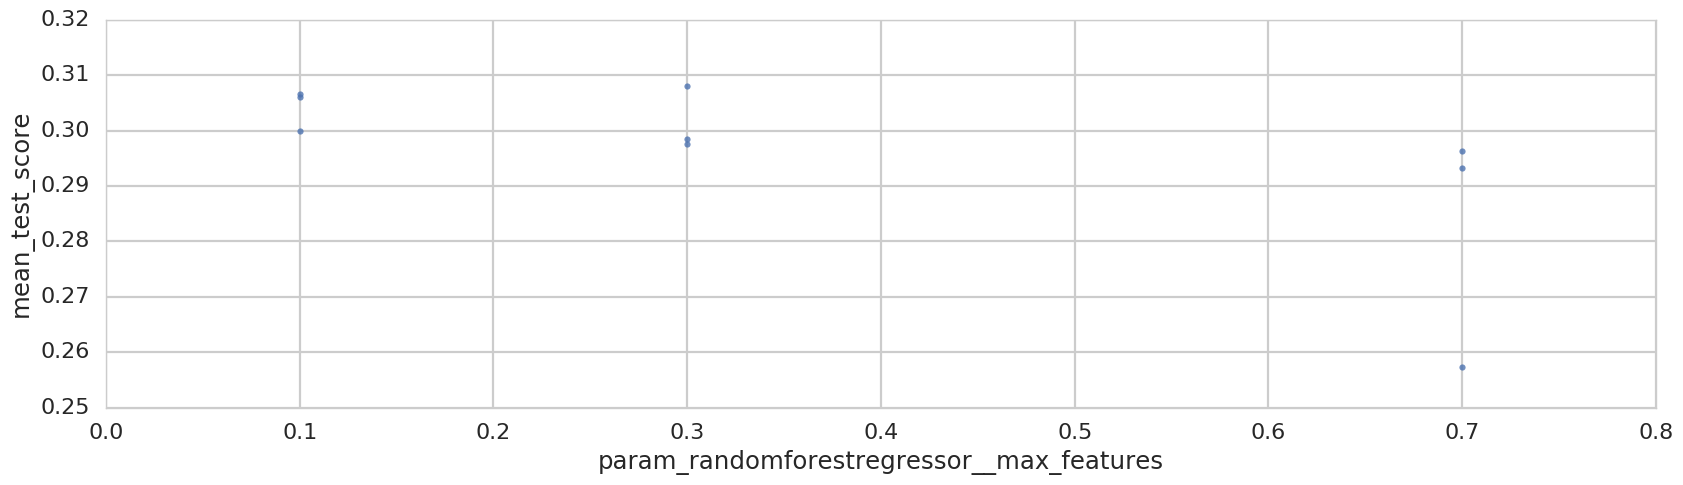

In [40]:
sns.regplot(
    x='param_randomforestregressor__max_features',
    y='mean_test_score',
    data=results.T[['param_randomforestregressor__max_features', 'mean_test_score']], 
    fit_reg=False
);

In [40]:
results.head(7)

,0,1,2,3,4,5
mean_fit_time,0.153448,0.366037,0.120166,0.356429,0.115375,0.306697
mean_score_time,0.0144906,0.0440918,0.0129309,0.0365126,0.0122641,0.0292189
mean_test_score,0.370416,0.373561,0.33807,0.389846,0.394492,0.392383
mean_train_score,0.875425,0.905297,0.888,0.900239,0.884884,0.898678
param_randomforestregressor__max_depth,160,160,200,200,230,230
param_randomforestregressor__max_features,0.95,0.95,0.95,0.95,0.95,0.95
param_randomforestregressor__n_estimators,10,30,10,30,10,30


In [55]:
model.best_params_

{'randomforestregressor__max_depth': 230,
 'randomforestregressor__max_features': 0.93,
 'randomforestregressor__n_estimators': 50}

In [46]:
model.score(X_test, y_test)

0.432155001397731

In [47]:
y_pred = model.predict(X_test)

In [59]:
mean_squared_error(y_test, y_pred)**0.5

309.67162762792412

In [48]:
adjusted_r2(y_test, y_pred, X_test.shape[1])

0.19744573530879314

### Feature Importance

In [56]:
feature_importances = pd.np.argsort(model.best_estimator_.steps[0][-1].feature_importances_)
features = list(df_dummified.drop('NUM_ISSUES', axis=1).columns[feature_importances[-1:-11:-1]])
pd.DataFrame({'top ten features': features})

,top ten features
0,value_std_dev
1,school_std_dev
2,bedroom_std_dev
3,earned_income_per_capita
4,value
5,income_std_dev
6,race_asian
7,housing_std_dev
8,rent_std_dev
9,rent


## Conclusion

Random Forests' improved performance implies that the data is not very linear. We're still overfitting, but it's the best we can do without dimensionality reduction or manual feature subselection.